In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import requests
from urllib.parse import urlencode

plt.style.use('ggplot')

In [2]:
# Чтение данных из облака
def download_link(public_key):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [3]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0, ymax=50, linestyle='--', colors='blue')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [4]:
df = pd.read_csv(download_link('https://disk.yandex.ru/d/MVklGfdRlIlcjA'),
                    sep=';', index_col=0)

In [5]:
df.dtypes

value                object
experimentVariant    object
dtype: object

In [6]:
# Т.к. с текстовым форматом не сработает вычисление медианы, переведём значения в числовой формат
df.value = df.value.str.replace(',', '.')
df.value = pd.to_numeric(df.value)

In [7]:
df.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

In [8]:
# Данные для двух групп

control_df = df.query("experimentVariant == 'Control'").value
treatment_df = df.query("experimentVariant == 'Treatment'").value

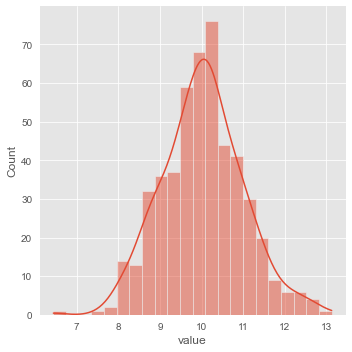

In [9]:
sns.displot(control_df, kde=True)

<AxesSubplot:xlabel='value', ylabel='Count'>

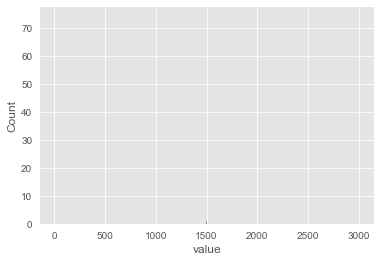

In [10]:
sns.histplot(treatment_df)

In [11]:
# Присутствуют явные выбросы. Построим гистограмму без них для понимания распределения
max_chosen_value = treatment_df.quantile(0.75) + 1.5 * (treatment_df.quantile(0.75) - treatment_df.quantile(0.25))

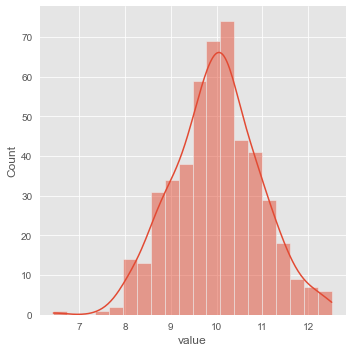

In [12]:
sns.displot(treatment_df.where(treatment_df < max_chosen_value), kde=True)

In [13]:
boot_it = 2000
boot_data = []
boot_conf_level = 0.95

for i in range(boot_it):

    samples = df['value'].sample(len(df['value']), replace = True)
    boot_data.append(np.mean(samples))

print(f'Original: {np.mean(df["value"])}, Boot: {np.mean(boot_data)}')

Original: 18.67418279523293, Boot: 18.649321452766983


  0%|          | 0/2000 [00:00<?, ?it/s]

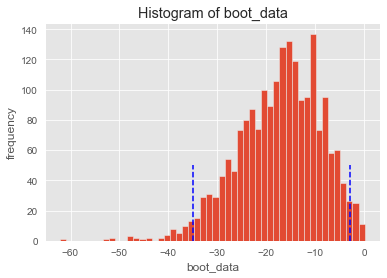

In [14]:
booted_data = get_bootstrap(control_df, treatment_df, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [15]:
booted_data["p_value"]

0.04145165877347212

In [16]:
booted_data["ci"]

,0
0.025,-35.045289
0.975,-2.920556


In [17]:
# Mann-whithey test
mannwhitneyu(control_df, treatment_df)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [18]:
boot_it = 2000
boot_data = []
boot_conf_level = 0.95

for i in range(boot_it):

    samples = df['value'].sample(len(df['value']), replace = True)
    boot_data.append(np.median(samples))

print(f'Original: {np.median(df["value"])}, Boot: {np.median(boot_data)}')

Original: 10.0208617676605, Boot: 10.0208617676605


  0%|          | 0/2000 [00:00<?, ?it/s]

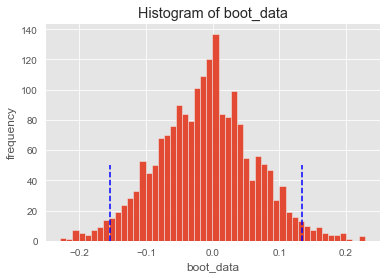

In [19]:
booted_data = get_bootstrap(control_df, treatment_df, boot_it = 2000, statistic=np.median) # в результате хранится разница двух распределений, ДИ и pvalue

In [20]:
booted_data["p_value"]

0.8841849363963177

In [21]:
booted_data["ci"]

,0
0.025,-0.153560
0.975,0.134511


Похоже, выбросы в группе treatment создают условия для отклонения нулевой гипотезы.
Проверим то же самое, удалив выбросы из группы

In [22]:
treatment_df_cor = treatment_df.where(treatment_df < max_chosen_value)\
                               .dropna()

  0%|          | 0/2000 [00:00<?, ?it/s]

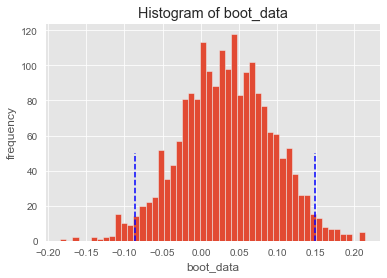

In [23]:
booted_data = get_bootstrap(control_df, treatment_df_cor, boot_it = 2000)

In [24]:
booted_data["p_value"]

0.5742153516179112

In [25]:
booted_data["ci"]

,0
0.025,-0.086326
0.975,0.148594


Полученные данные не позволяют отклонить нулевую гипотезу.
В первом случае, когда вычислялась разницу средних значений, было выявлено стат. значимое различие ввиду небольшого количества выбросов.
Во втором случае, когда вычисялась разница медиан, стат. значимого различия не было выявлено. Связано это с тем. что медианы менее подвержены сильным изменениям из-за выбросов.
U-критерий, слабо реагирующий на выбросы, показал корректный результат.